In [27]:
from pathlib import Path
import keras
from keras import layers
import tensorflow as tf
from model import Conv2Plus1D, ResizeVideo, add_residual_block
from dataloader import FrameGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [28]:
n_frames = 20
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

test_ds = tf.data.Dataset.from_generator(FrameGenerator(Path("data/test"), n_frames),
                                          output_signature = output_signature)
# Batch the data
test_ds = test_ds.batch(batch_size)

In [29]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

input_shape = (None, n_frames, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(input, x)

In [30]:
model.load_weights("checkpoints/mixed_20frames_10epochs.weights.h5")
model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [31]:
prob = model.predict(test_ds)
prob = tf.squeeze(prob)
y_pred = tf.cast(prob > 0.5, tf.int16)


167/167 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step


c:\Users\UserAdmin\anaconda3\envs\r3d\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [32]:
y_true = [labels for _, labels in test_ds.unbatch()]
y_true = tf.stack(y_true)

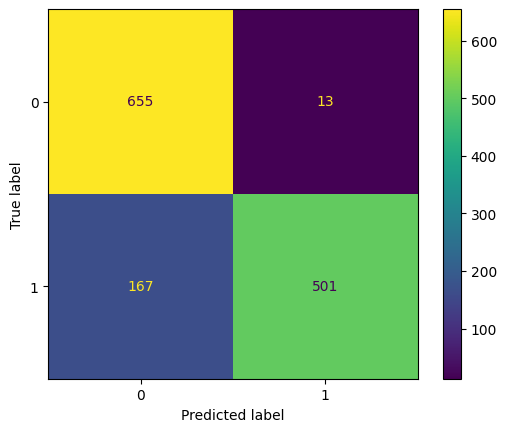

In [33]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [34]:
acc = accuracy_score(y_true, y_pred)
p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Accuracy:", acc)
print("Precision:", p)
print("Recall", r)
print("F1 score:", f1)

Accuracy: 0.8652694610778443
Precision: 0.9747081712062257
Recall 0.75
F1 score: 0.8477157360406091
